`comparaison_env`

In [1]:
import pandas as pd
import glob
import os 
import sys
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import entropy, pearsonr
from scipy.spatial.distance import jensenshannon

sys.path.append(os.path.abspath("/home/pelissier/These-ATER/Papier_international3/Dataset"))
from utils import *
sys.path.append('/home/pelissier/These-ATER/Papier_international3/Code')  # Adjust the path based on the relative location
from utils_comparaison import *
from metriques import *

Variables globales

In [ ]:
### MODELNET40 REMESHING ISO
ModelNet40_aligned_us = "/home/pelissier/These-ATER/Papier_international3/Code/Comparaison-User-study/Alignement/Dataset-aligned"
# Data des 12 caméras du Rendu
data_modelnet_cam = pd.read_csv("/home/pelissier/These-ATER/Papier_international3/Dataset/Rendu/ModelNet40/circular_config_12_elevation_30_R22.csv")
# Path ok (avec limper + projection + bvs)
paths_bvs = read_paths_from_txt("/home/pelissier/These-ATER/Papier_international3/Dataset/paths_files/obj_SMPLER_files_ModelNet40_remeshing_iso_user-study-844-ok.txt"); print("Fichiers bvs de Modelnet40 :", len(paths_bvs))
dir_bvs = "/home/pelissier/These-ATER/Papier_international3/Dataset/Rendu/ModelNet40/bvs_remeshing_iso"

##################################################################################################################################
### User study
# Path to the directory containing the csv files of the user study
dir_us = "/home/pelissier/These-ATER/Papier_internationale2/Validation/user_study/3D/post_traitement/csv_etude_Prolific"
# Data of camera poses in user study : i, j, theta, delta, X, Y, Z
data_us_cam = pd.read_csv("/home/pelissier/These-ATER/Papier_international3/Code/Comparaison-User-study/cam_pose_rep_etude_arrondi.csv")
label_us_cam = pd.read_csv("/home/pelissier/These-ATER/Papier_international3/Code/Comparaison-User-study/cam_rep_etude_label_arrondi.csv")
data_us_cam['label'] = list(label_us_cam['label'])
## Choix et bvs des 44 modeles 
dir_bvs_us = '/home/pelissier/These-ATER/Papier_internationale2/Validation/user_study/3D/post_traitement/csv_etude_Prolific/csv_etude_filtre/visualisation_filtre'
paths_bvs_us_csv = glob.glob(os.path.join(dir_bvs_us, "**", "*global_distribution_label.csv*"), recursive=True); print("Modeles de US : ",len(paths_bvs_us_csv))
# Path data folder of user study
dir_Data = "/home/pelissier/These-ATER/Papier_internationale2/Data"

##################################################################################################################################
# Correspondances entre les noms des modèles dans ModelNet10 et les noms des modèles dans l'User Study
match_ModelNet2US = {'airplane': 'A380', "chair":'chair107', 'bench': 'bench', 'dresser': 'cabinet-d', 'night_stand': 'cabinet-d', 'tv_stand': 'cabinet-t', 'vase': 'vase', 'cup':'cup', 'car': 'carVasa'}
# Outputs tmp
# Path of user-study outputs folder in Dataset
dir_outputs_visu = "/home/pelissier/These-ATER/Papier_international3/Code/Comparaison-User-study/visualisation_cams/"
dir_outputs_csv = "/home/pelissier/These-ATER/Papier_international3/Code/Comparaison-User-study/csv_files/"

In [3]:
list_categorie_us = ['carVasa', 'cup', "A380", "cabinet-d", "cabinet-t", "bench"]
list_categroie_us_sym = ['carVasa', 'cup', "A380", "cabinet", "bench"]

## Contraintes : quelles caméras de l'US on considère ?

In [4]:
## Condition
## Toutes les caméras 
#j_cam_us_ok = [0,1,2,3,4]

## Que les cameras de la couronne j==1
j_cam_us_ok = [1]

## Que les cameras de la couronne j==1 ou j == 2
#j_cam_us_ok = [1,2]

## Cameras

In [ ]:
## User study
# Coordonnées des caméras de l'étude utilateur
X_us = []; Y_us = []; Z_us = []; labels_us = []; I_us = []; J_us = []
for j in j_cam_us_ok:
    X_us += list(data_us_cam.loc[data_us_cam['j'] == j]['X_rep_etude'])
    Y_us += list(data_us_cam.loc[data_us_cam['j'] == j]['Y_rep_etude'])
    Z_us += list(data_us_cam.loc[data_us_cam['j'] == j]['Z_rep_etude'])
    I_us += list(data_us_cam.loc[data_us_cam['j'] == j]['i'])
    J_us += [j for _ in range(8)]
    labels_us += list(data_us_cam.loc[data_us_cam['j'] == j]['label']) 
cams_us = np.around(np.column_stack((X_us, Y_us, Z_us, np.array([1]*len(X_us)))),3)
R_sphere = list(data_us_cam['R'])[0]

## ModeleNet 
# Coordonnées des 12 caméras de ModelNet40 dans le repère de ModelNet40
X_modelnet = np.array(data_modelnet_cam['LocationX'][1:])
Y_modelnet = np.array(data_modelnet_cam['LocationY'][1:])
Z_modelnet = np.array(data_modelnet_cam['LocationZ'][1:])
cams_modelnet = np.column_stack((X_modelnet, Y_modelnet, Z_modelnet, np.array([1]*12)))
print("12 cams Modelnet dans repère Modelnet : \n", cams_modelnet)

In [ ]:
print(len(cams_us), "cams US", len(labels_us), "lables US")
print(str(len(cams_us))+" cams US considérées dans repère US : \n", cams_us, labels_us)

## Poids + BVS user study --> en fonction des caméras de l'us

In [7]:
all_bvs_us = {}
# Les POV qui nous intéressent sont ceux sur la couronne 'Milieu-Dessus', donc avec j == 1
for path_bvs_us_csv in paths_bvs_us_csv:
    name = os.path.basename(path_bvs_us_csv).split('_')[0]
    df = pd.read_csv(path_bvs_us_csv)
    # on ne garde que les info de caméra concidérées
    filter_df = df[df['label'].isin(labels_us)]
    filter_sorted_df = filter_df.sort_values(by='poids', ascending=False)
    # BVS : attention il put y avoir plusieurs BVS pour un même modèle <=> plusieurs labels avec le même poids
    label_bvs_mesh = list(filter_sorted_df.loc[filter_sorted_df['poids'] ==  max(list(filter_sorted_df['poids']))]['label'])
    position_bvs_mesh = [[i for i in range(len(labels_us)) if labels_us[i] in label_bvs_mesh]]
    # coordonnées 3D des caméras BVS dans le repère de l'US
    cam_bvs = np.concatenate([np.array(X_us)[position_bvs_mesh], np.array(Y_us)[position_bvs_mesh], np.array(Z_us)[position_bvs_mesh]]).T  
    # Indice I-J des caméras dans le repère de l'US
    i_j_cam = np.concatenate([np.array(I_us)[position_bvs_mesh], np.array(J_us)[position_bvs_mesh]]).T
    all_bvs_us[name] = {'df': filter_sorted_df, 'label_bvs': label_bvs_mesh, 'cam_bvs': cam_bvs, 'ij_bvs': i_j_cam, 'poids_bvs' :  max(list(filter_sorted_df['poids']))}

## Pour 1 categorie : cvs avec poids par caméras US

In [ ]:
categorie_modelnet = 'bench'
categorie_us = match_ModelNet2US[categorie_modelnet]; print(categorie_modelnet, categorie_us)
if 'cabinet' in categorie_us: categorie_us = 'cabinet'
print(categorie_modelnet, categorie_us)

In [ ]:
## Modele de l'US asscoié à la catégorie
#path_mesh_us = os.path.join(dir_Data, categorie_us, categorie_us+"_update_normed_centered_user_study.obj")
path_mesh_us = os.path.join(dir_Data, 'mesh_objectnet_regulier', categorie_us, categorie_us+"_regulier_tri_normed_centered_user_study.obj")
print(os.path.exists(path_mesh_us))

# dossier pour les visualisations
if not os.path.exists(os.path.join(dir_outputs_visu, categorie_modelnet)):
    os.makedirs(os.path.join(dir_outputs_visu, categorie_modelnet), exist_ok=True)
dir_outputs_visu_categorie = os.path.join(dir_outputs_visu, categorie_modelnet); print(dir_outputs_visu_categorie)

### Impact/Poids de la BVS de modelnet aligné sur les X cams US --> BVS sur l'ensemble des modèles 

In [ ]:
## Fichiers BVS de la categorie
paths_bvs = [paths_bvs[i] for i in range(len(paths_bvs)) if categorie_modelnet in paths_bvs[i]]; print("Fichiers bvs de la categorie dispo :", len(paths_bvs), paths_bvs[0])
random.shuffle(paths_bvs)
print(paths_bvs[0])

Création des fichiers CAT_distribution_global_modelnet-Xcams.csv

In [ ]:
all_bvs_modelnet = {}
## Df des poids de chaque mesh de la catégorie sur les caméras de l'US
df_poids_from_modelnet = pd.DataFrame(columns=['path', 'name']+[f"{int(I_us[k])}-{J_us[k]}" for k in range(len(I_us))])
df_poids_from_modelnet.loc[0] = [None, 'labels US'] + labels_us

if False:
    # Pour chacun des modèles de la catégorie étudée dont on a le fichier bvs (que 38 actuellement), issue de ModelNet40 (car : 296)
    for n in tqdm.tqdm(range(len(paths_bvs))):
        ###################################################################
        ## ModelNet40
        # Load model alignés à l'étude utilisateur
        path_mesh_n = paths_bvs[n]; #print(path_mesh_n)
        #path_mesh_n = "cup/train/cup_0039_SMPLER_centered_scaled_remeshing_iso_iter9"
        name_modelnet_n =  '_'.join(os.path.basename(path_mesh_n).split('_')[:3])
        df_poids_from_modelnet.loc[n+1, 'path'] = path_mesh_n; df_poids_from_modelnet.loc[n+1, 'name'] = name_modelnet_n
        # Load mesh PRÉALABLEMENT placé dans le REPRÈRE US (avec code Alignenment/align_mesh.ipynb)
        path_mesh_modelnet_aligned_n = os.path.join(ModelNet40_aligned_us, path_mesh_n+"_aligned_ok_US.obj")
        mesh_modelnet_aligned_n = trimesh.load_mesh(path_mesh_modelnet_aligned_n)
        centroid_modelnet_aligned_n = get_centroid(mesh_modelnet_aligned_n.faces, mesh_modelnet_aligned_n.vertices)
        # BVS du mesh ModelNet40 aligned
        cams_modelnet_mesh_n, cam_bvs_modelnet_n, num_cam_bvs_modelnet_n = bvs_cams_modelnet_aligned(path_mesh_n, path_mesh_modelnet_aligned_n, dir_bvs, cams_modelnet); #print("Modelnet", cam_bvs_modelnet_n, num_cam_bvs_modelnet_n)
        
        ## Objectif : trouver la "BVS moyenne"  <--> attribué un poids d'impact a chacun des cam de l'US
        # Impact de la camera BVS de modlenet40 sur les caméras de l'étude utilisateur
        df_poids_from_modelnet, cam_sphere = poids_modelnet_sur_US(df_poids_from_modelnet, cam_bvs_modelnet_n, centroid_modelnet_aligned_n, cams_us, R_sphere, I_us, J_us)

        ## OBJ : caméras modelent40 alignées avec US
        show_cams(mesh_modelnet_aligned_n, np.vstack((cam_bvs_modelnet_n, cam_sphere)), name_modelnet_n+"_sphere", None, None, None, dir_outputs_visu_categorie, US_obj=False)

        ###################################################################
        ## User stuy
        # mesh random from User_study
        mesh_us = trimesh.load_mesh(path_mesh_us)
        # BVS US
        cam_bvs_us = all_bvs_us[categorie_us]['cam_bvs']
        ## Double obj : len(cams_us) cameras US et 12 caméras modelent40 alignées avec US
        show_cams(mesh_modelnet_aligned_n, cams_modelnet_mesh_n, name_modelnet_n, mesh_us, cams_us, categorie_us,  dir_outputs_visu_categorie, US_obj=True)  
        
        
    ## impact de chaque mesh de la catégorie sur les caméras de l'US
    df_poids_from_modelnet.to_csv(os.path.join(dir_outputs_csv, categorie_modelnet+"_distribution_impact-"+str(len(X_us))+"cams.csv"))
        
    ###################################################################
    ## Normalisation  des poids de modelnet sur US 
    # Somme des poids pour chaque caméras
    verif = 0
    df_poids_from_modelnet_final = pd.DataFrame(columns=['label', 'poids'])
    for k in range(len(I_us)):
        label_poids_k = list(df_poids_from_modelnet.loc[:, f"{int(I_us[k])}-{J_us[k]}"])
        df_poids_from_modelnet_final.loc[k] = [label_poids_k[0], np.sum(label_poids_k[1:])] 
        verif += np.sum(label_poids_k[1:])
        
    ## verification
    if float(abs(verif - len(paths_bvs))<10e-2): print("Somme des poids OK")
    else: print("Erreur de somme des poids")

    ###################################################################   
    # ## BVS de la catégorie courante
    df_poids_from_modelnet_final_sorted = df_poids_from_modelnet_final.sort_values(by='poids', ascending=False)
    # # sauvegarde
    df_poids_from_modelnet_final_sorted.to_csv(os.path.join(dir_outputs_csv, categorie_modelnet+"_distribution_global_modelnet-"+str(len(X_us))+"cams.csv"))
    df_poids_from_modelnet_final_sorted

## Comparaison

In [12]:
#list_categorie_us = ['A380']

### Data des bvs de US et Modelnet pour chaque catégorie

In [ ]:
# Dicitonnaire : keys == categorie et values == info sur les BVS : cam, label, ij ....
BVS = {}
for cat_us in list_categorie_us :
    cat_m = [k for k, v in match_ModelNet2US.items() if v == cat_us][0]
    print(cat_m, cat_us)
    #categorie = categorie_us; print(categorie)

    ## bvs modelnet 
    df_bvs_modelnet = pd.read_csv(os.path.join(dir_outputs_csv, cat_m+"_distribution_global_modelnet-"+str(len(j_cam_us_ok)*8)+"cams.csv"))
    label_bvs_modelnet = list(df_bvs_modelnet.loc[df_bvs_modelnet['poids'] ==  max(list(df_bvs_modelnet['poids']))]['label'])
    position_bvs_modelenet = [[i for i in range(len(labels_us)) if labels_us[i] in label_bvs_modelnet]]
    # coordonnées 3D des caméras BVS dans le repère de l'US
    cam_bvs_modelnet = np.concatenate([np.array(X_us)[position_bvs_modelenet], np.array(Y_us)[position_bvs_modelenet], np.array(Z_us)[position_bvs_modelenet]]).T  
    # Indice I-J des caméras dans le repère de l'US
    ij_bvs_modelnet = np.concatenate([np.array(I_us)[position_bvs_modelenet], np.array(J_us)[position_bvs_modelenet]]).T
    #print('BVS modelenet dans repère US :\n', cam_bvs_modelnet, label_bvs_modelnet, ij_bvs_modelnet,"\n")

    ## bvs US
    cam_bvs_us = all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['cam_bvs']
    ij_bvs_us =  all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['ij_bvs']
    #print('US : \n', cam_bvs_us, all_bvs_us[cat_us]['label_bvs'], all_bvs_us[cat_us]['ij_bvs'])

    # Sauvegarde 
    BVS[cat_us] = {'modelnet': 
        {'cam': cam_bvs_modelnet, 
         'label': label_bvs_modelnet,
         'ij': ij_bvs_modelnet, 
         'df' : df_bvs_modelnet}, 
        'US': 
        {'cam': cam_bvs_us,
         'label': all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['label_bvs'], 
         'ij': all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['ij_bvs'], 
         'poids': all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['poids_bvs'], 
         'df' : all_bvs_us[['cabinet' if 'cabinet' in cat_us else cat_us][0]]['df']}, 'metriques': {}, 'metriques_sym': {}}
BVS.keys()

PS est le meme avec ou sans symetrique car on les prends déjà en compte dans la formule

In [ ]:
# ce que je prédis :
print(get_ds2(coord_U= [1.10,1.56,1.1], coord_M=[0, 1.56, 1.56], sig=1.5, epsilon=2), 19.4/34.1)


for cat_us in list_categorie_us:
    print(cat_us)
    # Proximity score : Magenta : US // Sym uS : Bleu // Modelnet : Vert
    PS, terme = score_proximite(BVS, cat_us, path_mesh_us, list_categroie_us_sym, data_us_cam, dir_outputs_visu_categorie, sig =1.5, epsilon=2); print(PS)
    BVS[cat_us]['metriques']['PS'] = (np.round(PS,3), terme)
    BVS[cat_us]['metriques_sym']['PS'] = (np.round(PS,3), terme)

# Pour normaliser les histogrammes (avec ou sans symétriques), on divise chacun par sa somme, comme ça la somme vaut 1 et les histogrammes peuvent être assimilés à des densité de probabilité discretes

### Avec symétriques

In [ ]:
df_exemple, _ = get_poids_from_BVS(BVS, cat_us, labels_us, data_us_cam); df_exemple

In [18]:
dict_metriques = {"Dnom" : lambda w1, w2 : Dnom(w1, w2),
                  "Dord" :  lambda w1, w2 : Dord(w1, w2),
                  "Dmod" :  lambda w1, w2 : Dmod(w1, w2),
                  "L2_norm" : lambda w1, w2 : np.linalg.norm(w1 - w2),
                  "L1_norm" : lambda w1, w2 : np.sum(np.abs(w1 - w2)),
                  "cos_sim" : lambda w1, w2 : 1 - cosine(w1, w2),
                  "fourier_dist" : lambda w1, w2 : fourier_similarity(w1, w2),
                  "corr-pv" : lambda w1, w2 : pearsonr(w1, w2),
                  "kl_div" : lambda w1, w2 : entropy(w2, w1),
                  "js_div" : lambda w1, w2 : jensenshannon(w1, w2),
                  "bhatta_dist" : lambda w1, w2 : -np.log(np.sum(np.sqrt(np.array(w1) * np.array(w2)))), 
                  "circu_dist" : lambda w1, w2 : np.sum(np.minimum(np.abs(w1 - w2), 1 - np.abs(w1 - w2)))}

In [ ]:
for cat_us in list_categorie_us:
    cat_m = [k for k, v in match_ModelNet2US.items() if v == cat_us][0]
    df_poids_both, _ = get_poids_from_BVS(BVS, cat_us, labels_us, data_us_cam)
    # sauvegarde poids 
    df_poids_both.to_csv(os.path.join(dir_outputs_csv, cat_us+"_poids_both.csv"))
    # Poids des caméras pour les deux méthodes (exemple)
    weights_method_us = np.array(df_poids_both['poids_us_norm'])
    weights_method_m = np.array(df_poids_both['poids_modelnet_norm'])
    ####### Visualisation des poids 
    cams = [list(data_us_cam.loc[data_us_cam['label'] == l].iloc[0])[6:9] for l in df_poids_both['label']]
    # pour avoir de jolies couleurs il faut que les poids soient entre 0 et 1
    weights_histo_us = [x / max(weights_method_us) for x in weights_method_us]
    show_cams_histogram(cat_m+"_histograms_us", cams, weights_histo_us, dir_outputs_visu+cat_m) 
    
    cams_ecartees = [[3 * x / 2.2, y, 3*z/2.2] for x,y,z in cams ]
    weights_histo_m = [x / max(weights_method_m) for x in weights_method_m]
    show_cams_histogram(cat_m+"_histograms_m", cams_ecartees, weights_histo_m, dir_outputs_visu+cat_m)
    
    # En 2D
    histogram_circulaire(weights_method_us, weights_method_m, dir_outputs_visu, cat_us)
    histograms_2D(weights_method_us, weights_method_m, np.array(df_poids_both['label']), dir_outputs_visu, cat_us)
    ####### Métriques
    for name, metrique in dict_metriques.items():
        BVS[cat_us]['metriques'][name] = np.round(metrique(weights_method_us, weights_method_m),3)
    
## Valeur idéales 
ideal ={}; a = weights_method_us; ideal['PS'] = 1
for name, metrique in dict_metriques.items():
    ideal[name] = np.round(metrique(a, a),3)
  
# Metriques
metriques = list(BVS[cat_us]['metriques'].keys())
df_metriques = pd.DataFrame(columns=['categorie',] + metriques)
df_metriques.loc[len(df_metriques)] = ['ideal']+[ideal[m] for m in metriques]
for cat_us in list_categorie_us:
    df_metriques.loc[len(df_metriques)+1] = [cat_us]+[BVS[cat_us]['metriques'][m] for m in metriques]
    
df_metriques.to_csv(os.path.join(dir_outputs_csv, "metriques_modelnet40_user_study.csv"))    
df_metriques

### Sans Symétrique

Pour les symétriques, on somme les pids, car chaque précédement on a normalier pour que chaque objet ait un impact de 1, donc en tout on a que la somme de tous les poids == nb objet. Si on prend le poids max entre les symétriques, on perd cette égalité. Donc on prend la somme.

In [ ]:
_, df_exemple_sym = get_poids_from_BVS(BVS, cat_us, labels_us, data_us_cam); df_exemple_sym

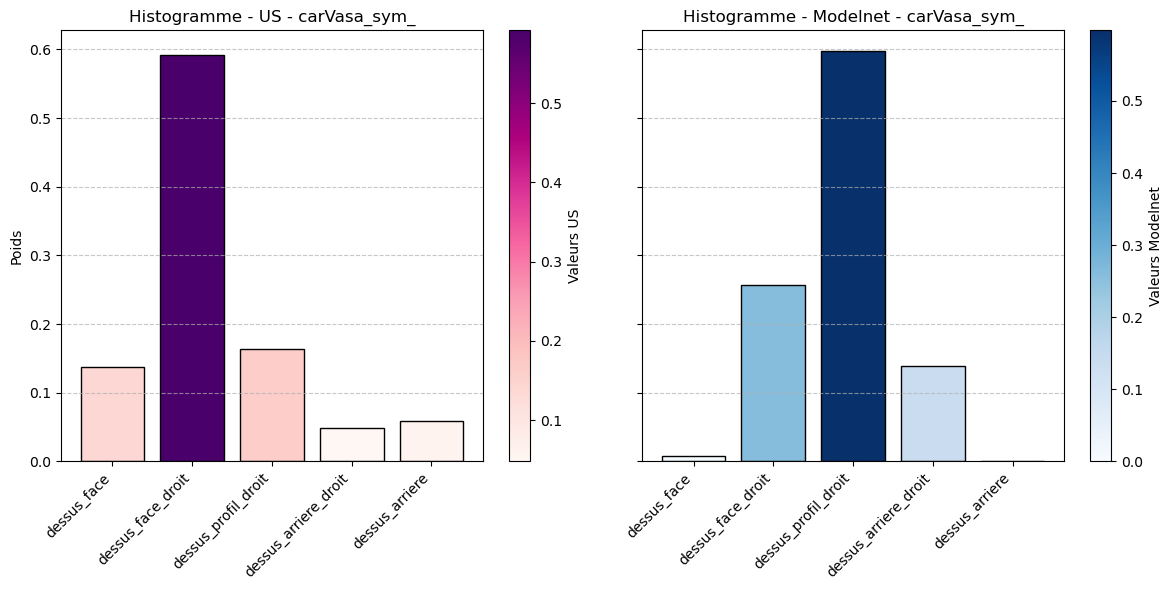

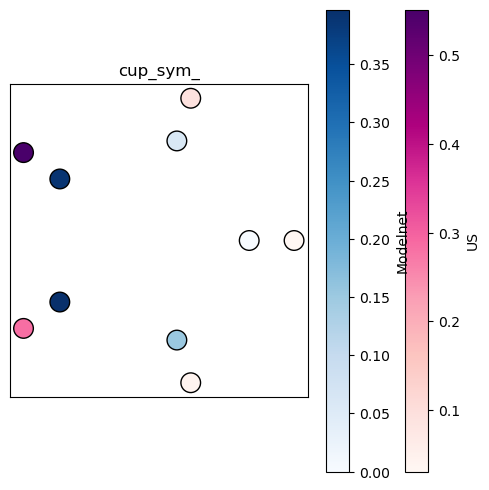

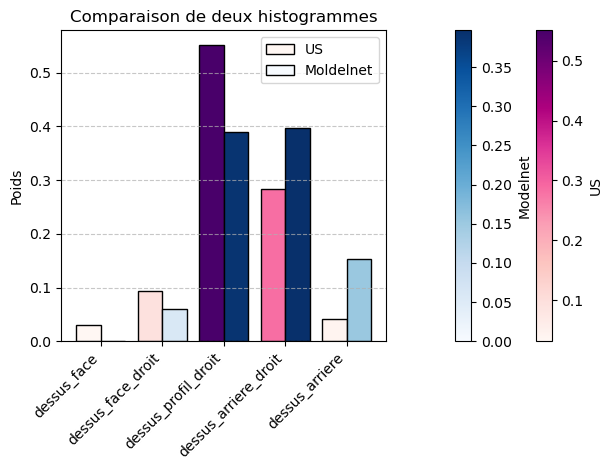

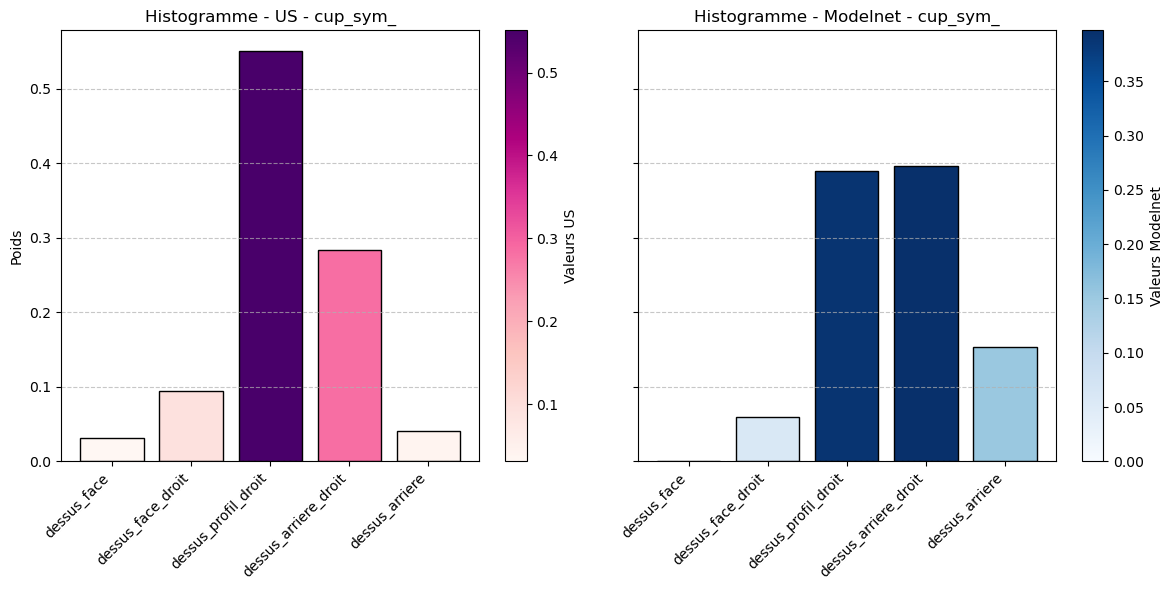

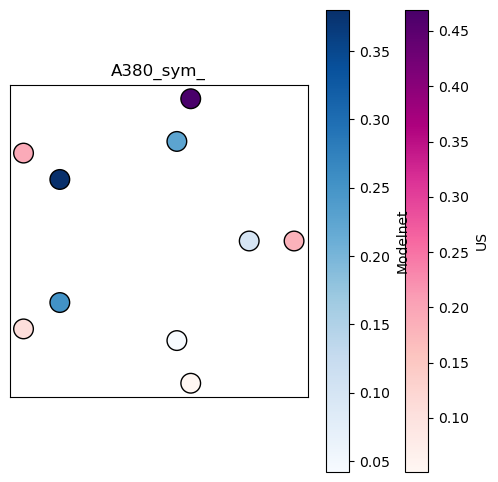

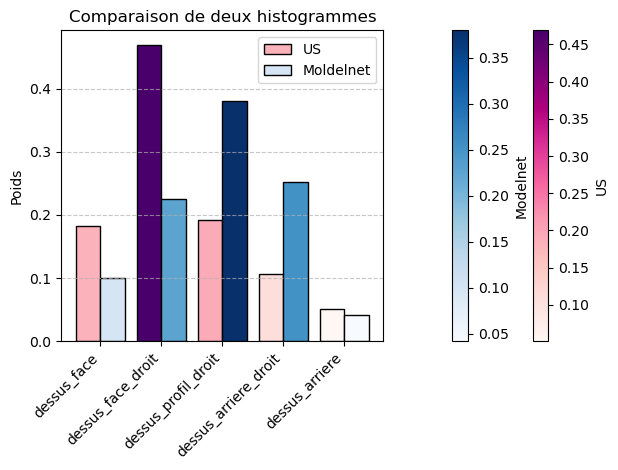

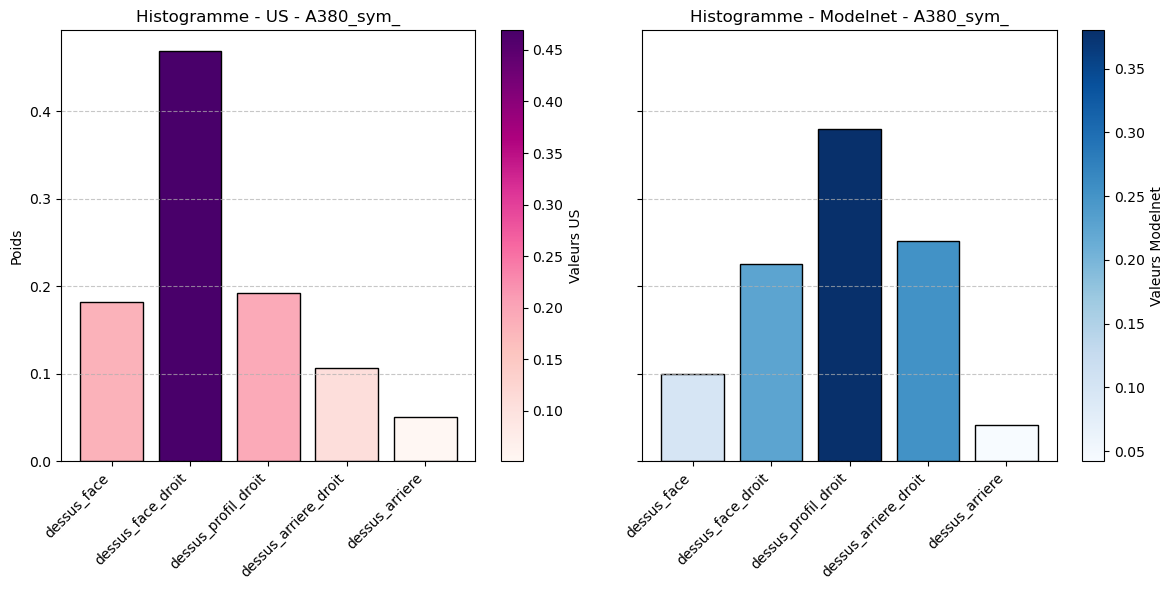

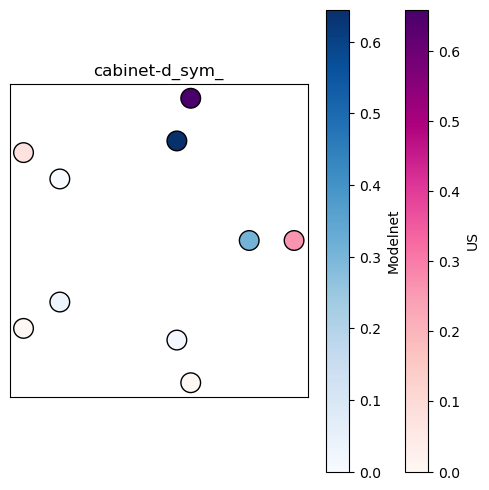

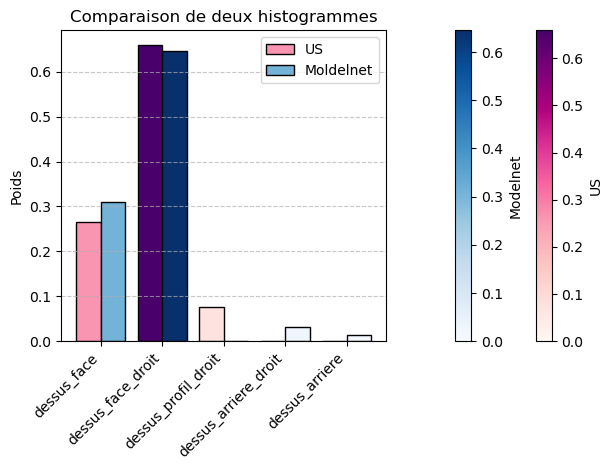

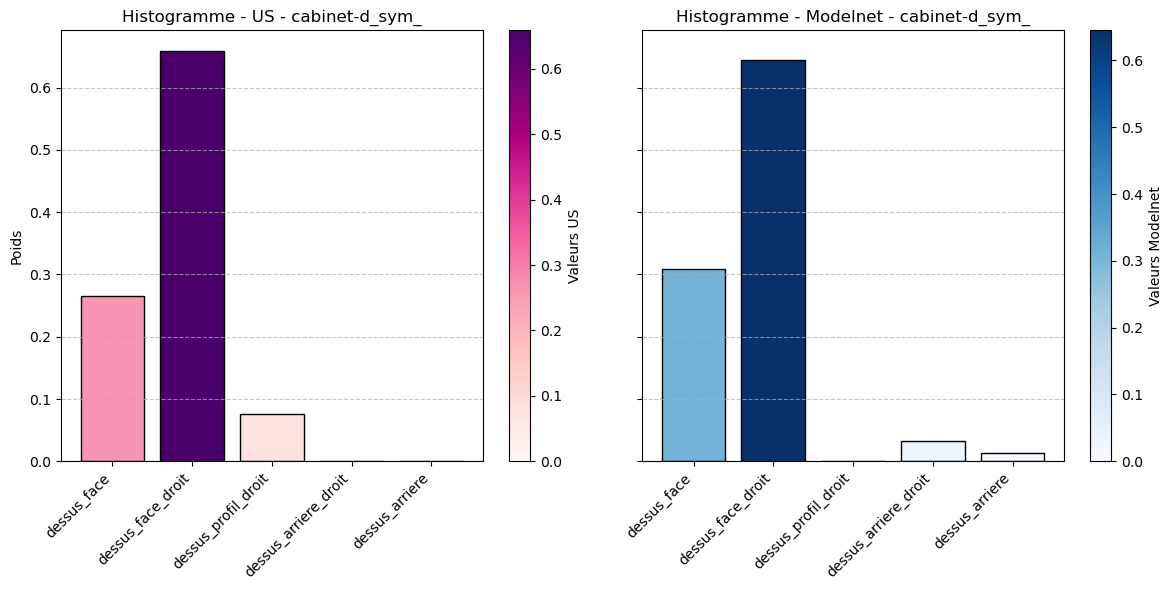

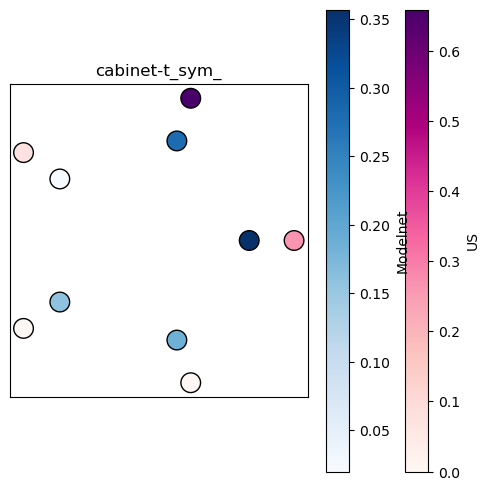

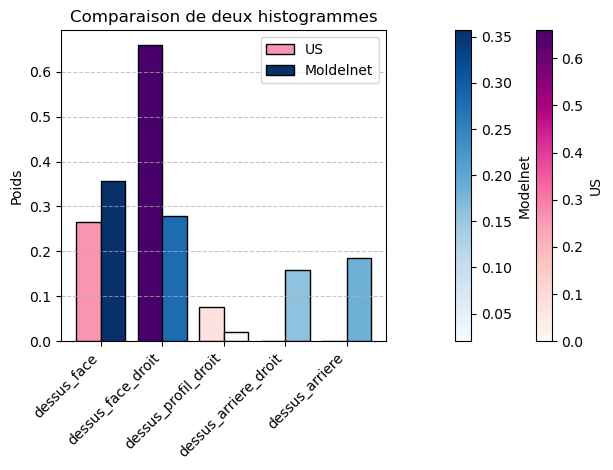

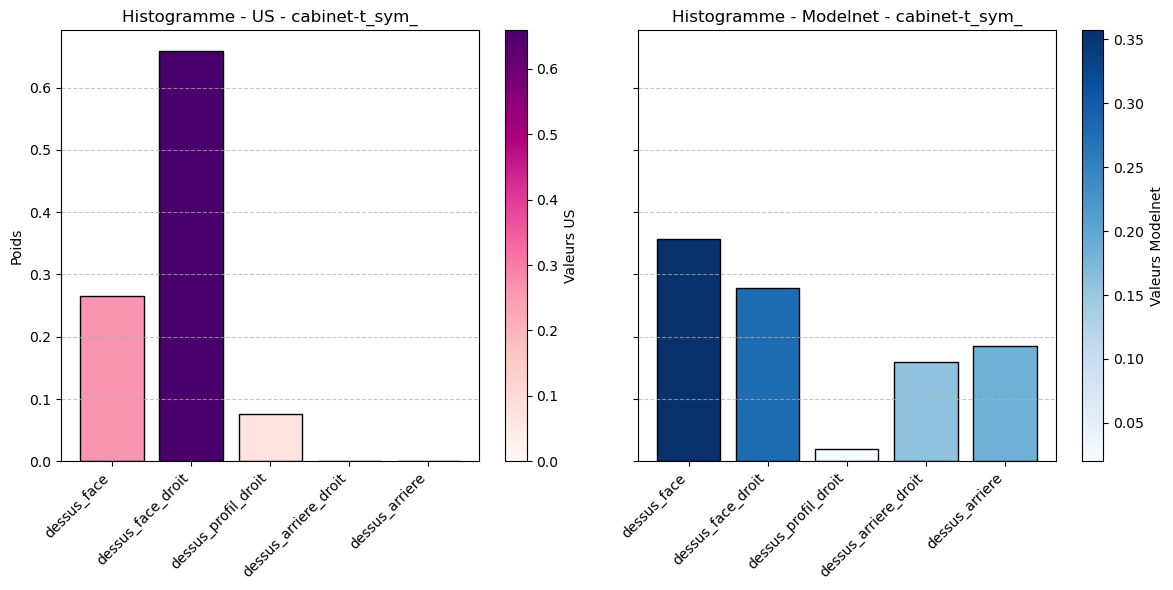

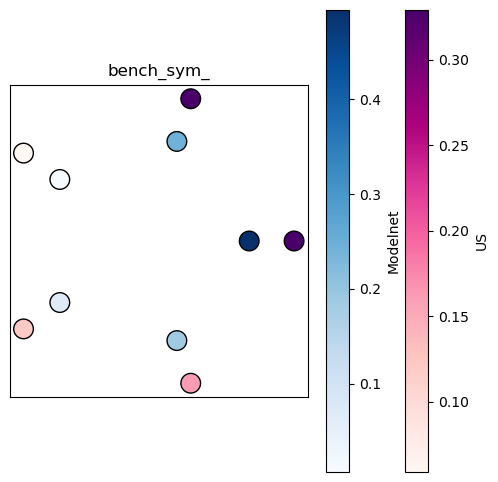

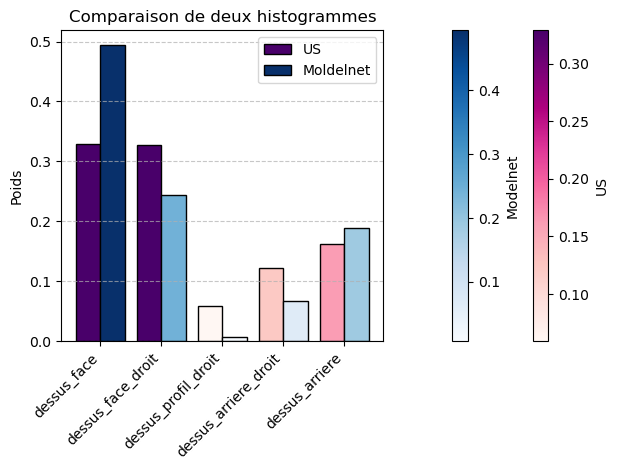

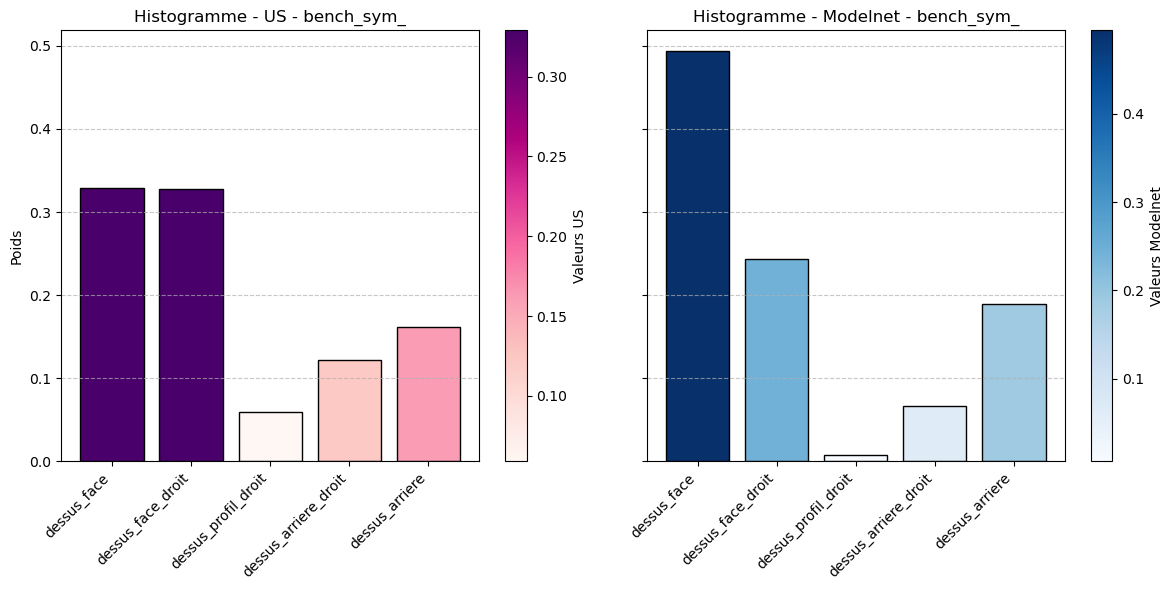

In [21]:
for cat_us in list_categorie_us:
    cat_m = [k for k, v in match_ModelNet2US.items() if v == cat_us][0]
    _, df_poids_both_sym = get_poids_from_BVS(BVS, cat_us, labels_us, data_us_cam)
    # sauvegarde poids 
    df_poids_both_sym.to_csv(os.path.join(dir_outputs_csv, cat_us+"_poids_both_sym.csv"))
    # Poids des caméras pour les deux méthodes (exemple)
    weights_method_us = np.array(df_poids_both_sym['poids_us_norm'])
    weights_method_m = np.array(df_poids_both_sym['poids_modelnet_norm'])
    ####### Visualisation des poids 
    cams = [list(data_us_cam.loc[data_us_cam['label'] == l].iloc[0])[6:9] for l in df_poids_both_sym['label']]
    show_cams_histogram(cat_m+"_histograms_us_sym", cams, weights_method_us, dir_outputs_visu+cat_m) 
    
    cams_ecartees = [[3 * x / 2.2, y, 3*z/2.2] for x,y,z in cams ]
    show_cams_histogram(cat_m+"_histograms_m_sym", cams_ecartees, weights_method_m, dir_outputs_visu+cat_m)
    
    # En 2D
    histogram_circulaire(weights_method_us, weights_method_m, dir_outputs_visu, cat_us+"_sym_")
    histograms_2D(weights_method_us, weights_method_m, np.array(df_poids_both_sym['label']), dir_outputs_visu, cat_us+"_sym_")
    
    ####### Métriques
    for name, metrique in dict_metriques.items():
        BVS[cat_us]['metriques_sym'][name] = np.round(metrique(weights_method_us, weights_method_m),3)
    
## Valeur idéales 
ideal ={}; a = weights_method_us; ideal['PS'] = 1
for name, metrique in dict_metriques.items():
    ideal[name] = np.round(metrique(a, a),3)

# Metriques
metriques_sym = list(BVS[cat_us]['metriques_sym'].keys())
df_metriques_sym = pd.DataFrame(columns=['categorie',] + metriques_sym)
df_metriques_sym.loc[len(df_metriques_sym)] = ['ideal']+[ideal[m] for m in metriques]
for cat_us in list_categorie_us:
    df_metriques_sym.loc[len(df_metriques_sym)+1] = [cat_us+"_sym"]+[BVS[cat_us]['metriques_sym'][m] for m in metriques_sym]
    
df_metriques_sym.to_csv(os.path.join(dir_outputs_csv, "metriques_modelnet40_user_study_sym.csv"))    
df_metriques_sym

## Visualisation globales des résultats

In [28]:
# Score du terme C dans PS en fonction de leccart entre les caméras
cam_u = [1.56,1.56,0]; sss=1.5
print("egalite", get_ds2(coord_U= cam_u, coord_M=cam_u, sig=sss, epsilon=2),"-- 1 pas : ", get_ds2(coord_U= cam_u, coord_M=[1.1,1.56,1.1], sig=sss, epsilon=2), "-- 2 pas : ", get_ds2(coord_U= cam_u, coord_M=[0,1.56,1.56], sig=sss, epsilon=2), "-- 3 pas : ", get_ds2(coord_U= cam_u, coord_M=[-1.1,1.56,1.1], sig=sss, epsilon=2), "-- 4 pas : ", get_ds2(coord_U= cam_u, coord_M=[-1.56,1.56,0], sig=sss, epsilon=2))

egalite 1.0 -- 1 pas :  0.73 -- 2 pas :  0.34 -- 3 pas :  0.16 -- 4 pas :  0.11


In [22]:
df_metriques

,categorie,PS,Dnom,Dord,Dmod,L2_norm,L1_norm,cos_sim,fourier_dist,corr-pv,kl_div,js_div,bhatta_dist,circu_dist
0,ideal,1,0.000,0.000,0.000,0.000,0.000,1.000,0.000,"[1.0, 0.0]",0.000,0.000,-0.000,0.000
2,carVasa,"(0.73, C)",0.526,1.411,0.813,0.449,1.051,0.565,1.269,"[0.048, 0.911]",0.777,0.428,0.226,1.051
3,cup,"(0.73, C)",0.227,0.437,0.435,0.199,0.454,0.901,0.564,"[0.738, 0.037]",0.194,0.217,0.055,0.454
4,A380,"(0.73, C)",0.333,0.564,0.548,0.258,0.666,0.795,0.729,"[0.066, 0.877]",0.261,0.252,0.067,0.666
5,cabinet-d,"(1, C)",0.090,0.175,0.135,0.079,0.181,0.990,0.224,"[0.983, 0.0]",inf,0.208,0.064,0.181
6,cabinet-t,"(0.75, W)",0.436,0.909,0.909,0.362,0.872,0.749,1.025,"[0.509, 0.197]",inf,0.416,0.258,0.872
7,bench,"(1, C)",0.192,0.635,0.299,0.187,0.383,0.956,0.528,"[0.964, 0.0]",0.109,0.174,0.034,0.383


In [23]:
df_metriques_sym

,categorie,PS,Dnom,Dord,Dmod,L2_norm,L1_norm,cos_sim,fourier_dist,corr-pv,kl_div,js_div,bhatta_dist,circu_dist
0,ideal,1,0.000,0.000,0.000,0.000,0.000,1.000,0.000,"[1.0, 0.0]",0.000,0.000,-0.000,0.000
2,carVasa_sym,"(0.73, C)",0.526,0.689,0.658,0.575,1.051,0.610,1.285,"[0.258, 0.675]",0.688,0.410,0.205,1.051
3,cup_sym,"(0.73, C)",0.226,0.434,0.307,0.231,0.452,0.930,0.518,"[0.852, 0.067]",0.174,0.204,0.048,0.452
4,A380_sym,"(0.73, C)",0.333,0.553,0.469,0.350,0.667,0.789,0.782,"[0.304, 0.618]",0.243,0.242,0.061,0.667
5,cabinet-d_sym,"(1, C)",0.090,0.134,0.134,0.096,0.180,0.991,0.214,"[0.985, 0.002]",inf,0.208,0.064,0.180
6,cabinet-t_sym,"(0.75, W)",0.436,0.909,0.909,0.464,0.872,0.761,1.038,"[0.562, 0.324]",inf,0.413,0.254,0.872
7,bench_sym,"(1, C)",0.192,0.302,0.271,0.202,0.383,0.942,0.451,"[0.876, 0.051]",0.102,0.166,0.029,0.383


egalite 1.0 -- 1 pas :  0.73 -- 2 pas :  0.34 -- 3 pas :  0.16 -- 4 pas :  0.11
